# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 506 kB 30.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 241 kB 22.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 65 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 146 kB 67.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 50 kB 8.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.lab11 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [10]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [11]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [12]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [13]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247763,-77.5634734,100mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'covid19' <span style="color:red;font-weight:bold"> AND </span> are located in Richmond, VA

In [16]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [17]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Nov 17 18:30:19 +0000 2021'
'Wed Nov 17 18:30:01 +0000 2021'
'Wed Nov 17 18:25:29 +0000 2021'
'Wed Nov 17 18:25:02 +0000 2021'
'Wed Nov 17 18:25:00 +0000 2021'
'Wed Nov 17 18:24:59 +0000 2021'
'Wed Nov 17 18:21:01 +0000 2021'
'Wed Nov 17 18:21:00 +0000 2021'
'Wed Nov 17 18:19:35 +0000 2021'
'Wed Nov 17 18:19:07 +0000 2021'
'Wed Nov 17 18:16:23 +0000 2021'
'Wed Nov 17 18:15:53 +0000 2021'
'Wed Nov 17 18:15:15 +0000 2021'
'Wed Nov 17 18:15:10 +0000 2021'
'Wed Nov 17 18:14:13 +0000 2021'
'Wed Nov 17 18:13:42 +0000 2021'
'Wed Nov 17 18:12:05 +0000 2021'
'Wed Nov 17 18:11:02 +0000 2021'
'Wed Nov 17 18:09:18 +0000 2021'
'Wed Nov 17 18:08:54 +0000 2021'
'Wed Nov 17 18:06:46 +0000 2021'
'Wed Nov 17 18:06:27 +0000 2021'
'Wed Nov 17 18:06:05 +0000 2021'
'Wed Nov 17 18:05:20 +0000 2021'
'Wed Nov 17 18:05:07 +0000 2021'
'Wed Nov 17 18:04:01 +0000 2021'
'Wed Nov 17 18:03:06 +0000 2021'
'Wed Nov 17 18:02:11 +0000 2021'
'Wed Nov 17 18:02:03 +0000 2021'
'Wed Nov 17 18:01:59 +0000 2021'
'Wed Nov 1

'Wed Nov 17 06:00:04 +0000 2021'
'Wed Nov 17 05:51:15 +0000 2021'
'Wed Nov 17 05:49:40 +0000 2021'
'Wed Nov 17 05:42:02 +0000 2021'
'Wed Nov 17 05:39:51 +0000 2021'
'Wed Nov 17 05:35:25 +0000 2021'
'Wed Nov 17 05:34:26 +0000 2021'
'Wed Nov 17 05:21:52 +0000 2021'
'Wed Nov 17 05:20:27 +0000 2021'
'Wed Nov 17 05:10:00 +0000 2021'
'Wed Nov 17 05:03:02 +0000 2021'
'Wed Nov 17 04:47:47 +0000 2021'
'Wed Nov 17 04:42:47 +0000 2021'
'Wed Nov 17 04:37:01 +0000 2021'
'Wed Nov 17 04:23:49 +0000 2021'
'Wed Nov 17 04:23:10 +0000 2021'
'Wed Nov 17 04:10:45 +0000 2021'
'Wed Nov 17 04:10:28 +0000 2021'
'Wed Nov 17 04:09:46 +0000 2021'
'Wed Nov 17 04:04:32 +0000 2021'
'Wed Nov 17 04:03:30 +0000 2021'
'Wed Nov 17 04:03:29 +0000 2021'
'Wed Nov 17 04:03:29 +0000 2021'
'Wed Nov 17 03:45:44 +0000 2021'
'Wed Nov 17 03:42:46 +0000 2021'
'Wed Nov 17 03:42:25 +0000 2021'
'Wed Nov 17 03:38:37 +0000 2021'
'Wed Nov 17 03:32:38 +0000 2021'
'Wed Nov 17 03:03:47 +0000 2021'
'Wed Nov 17 03:00:16 +0000 2021'
'Wed Nov 1

'Tue Nov 16 16:05:03 +0000 2021'
'Tue Nov 16 16:03:09 +0000 2021'
'Tue Nov 16 16:02:16 +0000 2021'
'Tue Nov 16 16:00:15 +0000 2021'
'Tue Nov 16 16:00:11 +0000 2021'
'Tue Nov 16 15:54:58 +0000 2021'
'Tue Nov 16 15:52:54 +0000 2021'
'Tue Nov 16 15:51:51 +0000 2021'
'Tue Nov 16 15:49:14 +0000 2021'
'Tue Nov 16 15:46:26 +0000 2021'
'Tue Nov 16 15:46:09 +0000 2021'
'Tue Nov 16 15:45:34 +0000 2021'
'Tue Nov 16 15:42:17 +0000 2021'
'Tue Nov 16 15:41:56 +0000 2021'
'Tue Nov 16 15:40:24 +0000 2021'
'Tue Nov 16 15:35:07 +0000 2021'
'Tue Nov 16 15:33:53 +0000 2021'
'Tue Nov 16 15:33:26 +0000 2021'
'Tue Nov 16 15:32:05 +0000 2021'
'Tue Nov 16 15:30:24 +0000 2021'
'Tue Nov 16 15:30:20 +0000 2021'
'Tue Nov 16 15:30:01 +0000 2021'
'Tue Nov 16 15:29:40 +0000 2021'
'Tue Nov 16 15:26:35 +0000 2021'
'Tue Nov 16 15:24:28 +0000 2021'
'Tue Nov 16 15:23:53 +0000 2021'
'Tue Nov 16 15:23:03 +0000 2021'
'Tue Nov 16 15:21:34 +0000 2021'
'Tue Nov 16 15:19:34 +0000 2021'
'Tue Nov 16 15:15:59 +0000 2021'
'Tue Nov 1

'Mon Nov 15 18:11:13 +0000 2021'
'Mon Nov 15 18:10:05 +0000 2021'
'Mon Nov 15 18:10:00 +0000 2021'
'Mon Nov 15 18:08:02 +0000 2021'
'Mon Nov 15 18:04:41 +0000 2021'
'Mon Nov 15 18:04:41 +0000 2021'
'Mon Nov 15 18:03:53 +0000 2021'
'Mon Nov 15 18:01:57 +0000 2021'
'Mon Nov 15 18:01:12 +0000 2021'
'Mon Nov 15 18:01:11 +0000 2021'
'Mon Nov 15 18:00:13 +0000 2021'
'Mon Nov 15 18:00:01 +0000 2021'
'Mon Nov 15 17:59:20 +0000 2021'
'Mon Nov 15 17:59:08 +0000 2021'
'Mon Nov 15 17:58:33 +0000 2021'
'Mon Nov 15 17:55:29 +0000 2021'
'Mon Nov 15 17:51:09 +0000 2021'
'Mon Nov 15 17:48:50 +0000 2021'
'Mon Nov 15 17:47:20 +0000 2021'
'Mon Nov 15 17:46:53 +0000 2021'
'Mon Nov 15 17:46:23 +0000 2021'
'Mon Nov 15 17:45:46 +0000 2021'
'Mon Nov 15 17:45:00 +0000 2021'
'Mon Nov 15 17:40:40 +0000 2021'
'Mon Nov 15 17:36:59 +0000 2021'
'Mon Nov 15 17:32:41 +0000 2021'
'Mon Nov 15 17:31:00 +0000 2021'
'Mon Nov 15 17:30:48 +0000 2021'
'Mon Nov 15 17:30:08 +0000 2021'
'Mon Nov 15 17:26:39 +0000 2021'
'Mon Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [18]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

991
591


Create a text index and print the Tweets containing specific keywords. 

In [9]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [10]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [11]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: mark
text: RT @Mia4MD: Early Voting is happening NOW in Maryland for the 2020 Presidential Election. You can vote in an early voting center in the cou…
----
name: megaminimalist
text: RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 million Texans have voted!  That’s 88% of all the 2016 votes. 

There is little mail-in voting…
----
name: Virginians4U
text: KEEP Pres: TRUMP
CHANGE Senate: GADE
HOPE Congress GOOD or FREITAS or TAYLOR or BENJAMIN or ANDREWS 
VOTE VOTE VOTE… https://t.co/2ZjF6E0Blv
----
name: Antonio Licon
text: #VOTE
----
name: jtevans
text: #Vote
----
name: Toto
text: RT @grantstern: Why is ⁦@MayorGimenez⁩ against social distancing during voting in #Miami?

Because he knows that suppressing the vote will…
----
name: Kiran Riar
text: RT @raquelmiranda89: Shelby County: you have today and tomorrow to early vote. That is it! After Thursday, your last chance to vote in pers…
----
name: Kirby Mendyk
text: I'm not voting until a celebrity tweets a picture of their taint

In [12]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [13]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,metadata,display_text_range
0,5f9970e6ea281243abe9e85f,Wed Oct 28 13:23:45 +0000 2020,1321442530572066817,1321442530572066817,RT @Mia4MD: Early Voting is happening NOW in M...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891425160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f9970eaea281243abe9e8c9,Wed Oct 28 13:23:49 +0000 2020,1321442549718945792,1321442549718945792,RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 m...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f9970efea281243abe9e939,Wed Oct 28 13:23:54 +0000 2020,1321442568459198467,1321442568459198467,KEEP Pres: TRUMP\nCHANGE Senate: GADE\nHOPE Co...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,...,en,1603891434193,1.321379e+18,1321378894327484416,{'created_at': 'Wed Oct 28 09:10:53 +0000 2020...,"{'url': 'https://t.co/g07jyouj2s', 'expanded':...",{'full_text': 'KEEP Pres: TRUMP CHANGE Senate:...,NaN,NaN,NaN
3,5f997133ea281243abe9ea5a,Wed Oct 28 13:25:02 +0000 2020,1321442853244018690,1321442853244018690,#VOTE,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,und,1603891502091,1.321441e+18,1321440905098874882,{'created_at': 'Wed Oct 28 13:17:17 +0000 2020...,"{'url': 'https://t.co/SiYtZzvyXq', 'expanded':...",NaN,NaN,NaN,NaN
4,5f9970e6ea281243abe9e868,Wed Oct 28 13:23:45 +0000 2020,1321442531532435457,1321442531532435457,#Vote,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,und,1603891425389,1.321180e+18,1321179867052986368,{'created_at': 'Tue Oct 27 20:00:01 +0000 2020...,"{'url': 'https://t.co/VhdpN9qfYf', 'expanded':...",NaN,NaN,NaN,NaN
5,5f9970f5ea281243abe9e9b4,Wed Oct 28 13:24:00 +0000 2020,1321442594174455809,1321442594174455809,RT @grantstern: Why is ⁦@MayorGimenez⁩ against...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1603891440324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5f9970eaea281243abe9e8c6,Wed Oct 28 13:23:49 +0000 2020,1321442549379334144,1321442549379334144,RT @raquelmiranda89: Shelby County: you have t...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429644,1.316336e+18,1316335746702340097,{'created_at': 'Wed Oct 14 11:11:13 +0000 2020...,"{'url': 'https://t.co/AbysBKfi2s', 'expanded':...",NaN,NaN,NaN,NaN
7,5f9970f9ea281243abe9ea15,Wed Oct 28 13:24:04 +0000 2020,1321442610347737088,1321442610347737088,I'm not voting until a celebrity tweets a pict...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,...,en,1603891444180,NaN,NaN,NaN,NaN,{'full_text': 'I'm not voting until a celebrit...,NaN,NaN,NaN
8,5f997133ea281243abe9ea5b,Wed Oct 28 13:25:02 +0000 2020,1321442853617164289,1321442853617164289,RT @kkjjPNW: You do not have to vote by mail i...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891502180,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
9,5f9970faea281243abe9ea39,Wed Oct 28 13:24:05 +0000 2020,1321442617138286594,1321442617138286594,RT @Carnage4Life: It’s easier for a white pers...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891445799,1.320028e+18,1320027534789140480,{'created_at': 'Sat Oct 24 15:41:03 +0000 2020...,"{'url': 'https://t.co/8u0q776vmb', 'expanded':...",NaN,NaN,NaN,NaN


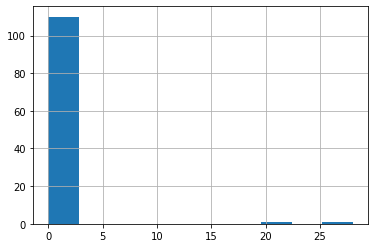

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count